In [1]:
#sandbox = 
#PATH_DATA = '/data/sandboxes/'+sandbox+'/data/data/'

DATA_PATH = "/content/drive/My Drive/Formación/Data Specialist/Guorchop/data_spark/"
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.2.1-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline

import re
import random
import string
from collections import Counter

import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
sns.set(color_codes=True)
from pyspark.sql import functions as F
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.stat import Statistics

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive




# Workshop de Spark

Cargamos un dataset con información de una campaña de marketing portuguesa para la venta de un préstamo bancario. El objetivo es, una vez limpiado el dataset, estudiarlo para extraer el máximo número de insights de los datos.



## Lectura de datos

In [2]:
bank_df = spark.read.csv('file:///'+DATA_PATH+'/bank-full.csv', sep=';', header=True, inferSchema=True)
bank_df.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|  y|picked_up_call|extra_info|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|2008|     261|       1|   -1|       0| unknown| no|             1|         1|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|2008|     151|       1|   -1|       0| unknown| no|             1|         1|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|2008|      76|       1|   -1|       0| unknown| no|             1|         1|
| 47| blue-collar| married| 

Dimensiones del dataset:

In [0]:
nrows = bank_df.count()
ncols = len(bank_df.columns)

Comprobamos si los nombres de las columnas siguen buenas prácticas

In [4]:
bank_df_colnames_list = bank_df.columns
colnames_best_practices = True
for col_name in bank_df_colnames_list:
  if col_name.isupper() | col_name.find('-') != -1 | col_name.find(' ') != -1:
    colnames_best_practices = False
    colname = colname.lower().replace('-','_').replace(' ','_')
print('This dataset is compliant with naming best practices: ',colnames_best_practices)

This dataset is compliant with naming best practices:  True


Una vez estudiada la descripción de los datos, comprobamos los tipos

In [5]:
bank_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- picked_up_call: integer (nullable = true)
 |-- extra_info: integer (nullable = true)



In [0]:
original_types_list = bank_df.dtypes
original_cat = [col_name for col_name,col_type in original_types_list if col_type == 'string']
original_num = [col_name for col_name,col_type in original_types_list if col_type != 'string']

## Análisis univariante

### Variables categóricas

Metemos en un diccionario el número de valores distintos posibles para cada variable categórica

In [7]:
cat_uniques = dict()
for col_name in original_cat:
  cat_uniques[col_name] = bank_df.select(col_name).distinct().count()
cat_uniques

{'contact': 3,
 'default': 2,
 'education': 4,
 'housing': 2,
 'job': 12,
 'loan': 2,
 'marital': 3,
 'month': 12,
 'poutcome': 4,
 'y': 2}

Recorremos el diccionario para **mostrar** los valores únicos que toman las variables categóricas

In [8]:
for col,value in cat_uniques.items():
  bank_df.select(col).distinct().show(value)
  

+-------------+
|          job|
+-------------+
|   management|
|      retired|
|      unknown|
|self-employed|
|      student|
|  blue-collar|
| entrepreneur|
|       admin.|
|   technician|
|     services|
|    housemaid|
|   unemployed|
+-------------+

+--------+
| marital|
+--------+
|divorced|
| married|
|  single|
+--------+

+---------+
|education|
+---------+
|  unknown|
| tertiary|
|secondary|
|  primary|
+---------+

+-------+
|default|
+-------+
|     no|
|    yes|
+-------+

+-------+
|housing|
+-------+
|     no|
|    yes|
+-------+

+----+
|loan|
+----+
|  no|
| yes|
+----+

+---------+
|  contact|
+---------+
|  unknown|
| cellular|
|telephone|
+---------+

+-----+
|month|
+-----+
|  jun|
|  aug|
|  may|
|  feb|
|  sep|
|  mar|
|  oct|
|  jul|
|  nov|
|  apr|
|  dec|
|  jan|
+-----+

+--------+
|poutcome|
+--------+
| success|
| unknown|
|   other|
| failure|
+--------+

+---+
|  y|
+---+
| no|
|yes|
+---+



Seleccionamos las variables categóricas con 2 valores para ser convertidas a booleanas

In [9]:
cat_to_bool = []
for col_name in original_cat:
  if cat_uniques[col_name] == 2:
    cat_to_bool.append(col_name)
cat_to_bool

['default', 'housing', 'loan', 'y']

Hacemos una representación en diagrama de barras de las variables categóricas

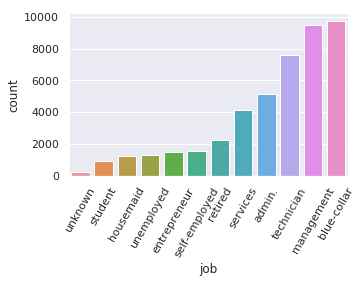

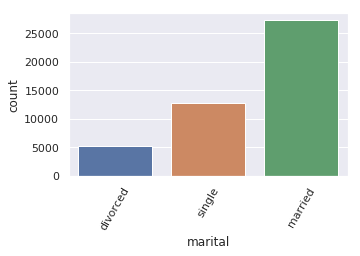

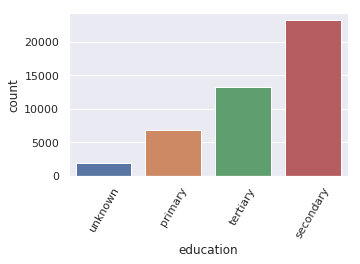

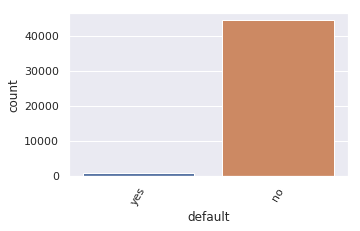

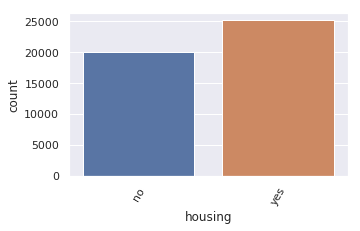

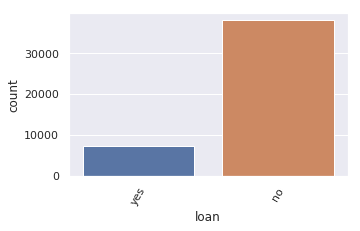

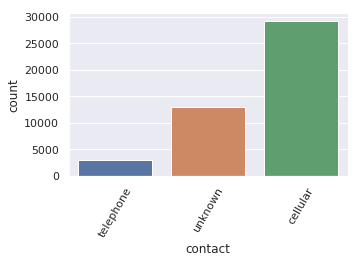

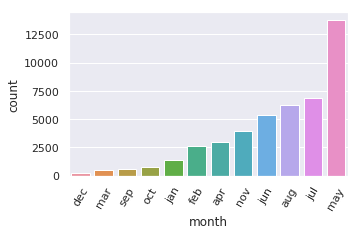

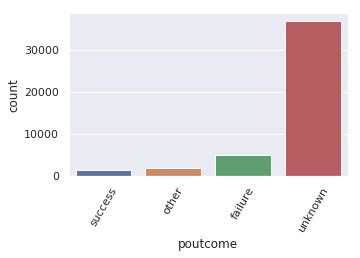

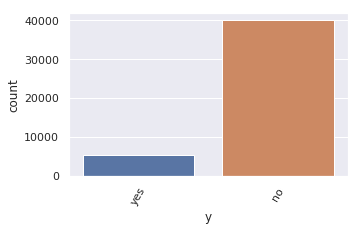

In [10]:
for var in original_cat:
  value_counts = bank_df.groupby(var).count().toPandas().sort_values('count')
  plt.figure(figsize=(5,3))
  sns.barplot(value_counts[var], value_counts['count'])
  plt.xticks(rotation=60)

Data insights sobre nuestra población:

- Los valores más frecuentes (modas) en nuestra población corresponden a individuos casados, de clase trabajadora (blue collar), con estudios secundarios, contactados mediante móvil que no tienen crédito en mora ni prestamos personales. Nosotros hubiesemos excluido de partida de la campaña los prospect con mora del target de la campaña
- Aunque la mayor parte de los individuos de nuestra población tienen hipoteca, la distribución en este campo está repartida. 
- Llama la atención la estacionalidad de las campañas en los meses de primavera verano (especialmente mayo)
- El éxito de la campaña parece mejorable

### Variables numéricas

Hacemos una representación en histograma de las variables numéricas

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


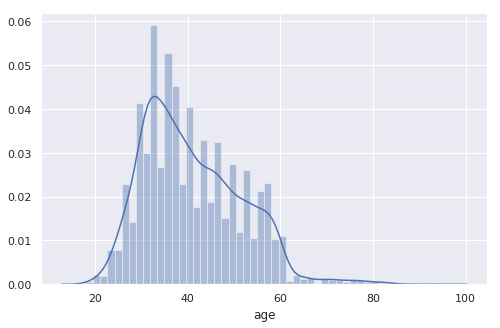

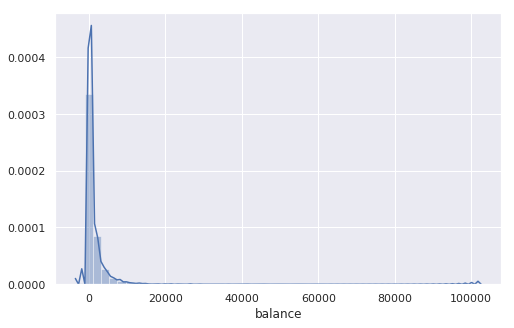

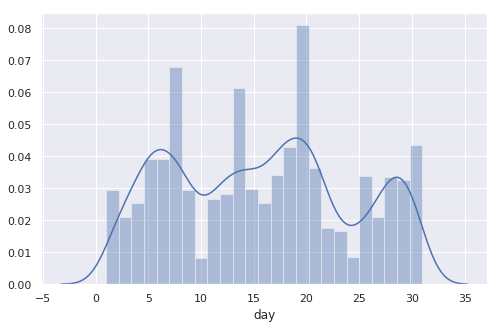

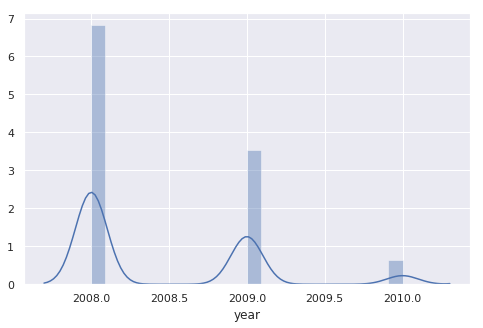

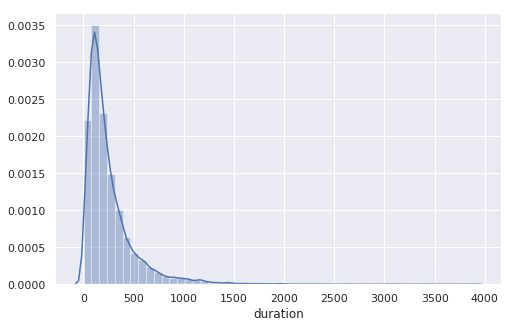

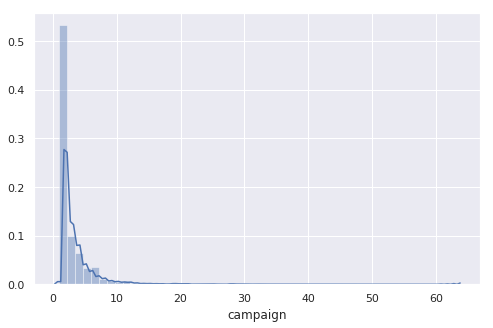

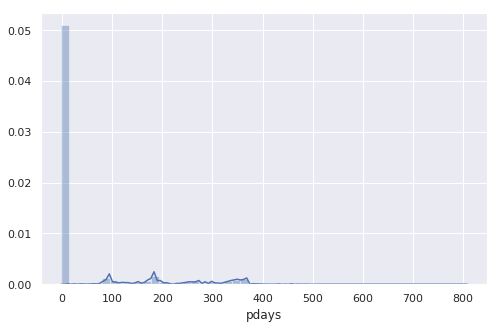

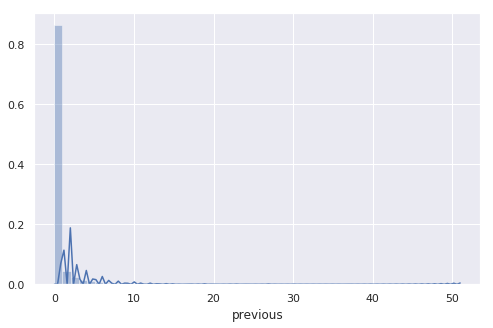

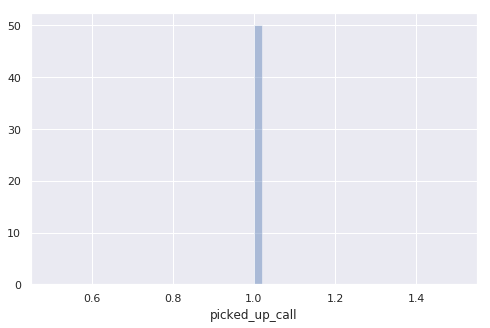

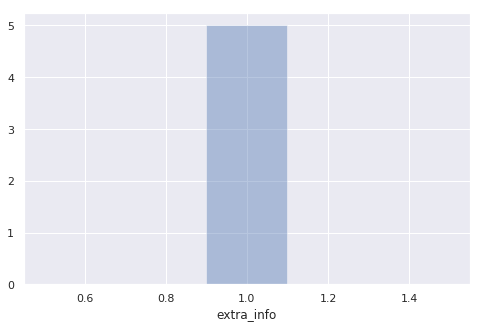

In [11]:

for var in original_num:
  sample_data = bank_df.select(var).filter(F.col(var).isNotNull()).sample(False, fraction=10000/nrows, seed=77).toPandas()
  plt.figure(figsize=(8, 5))
  sns.distplot(sample_data[var])

**Conclusiones de los histogramas**

* Variables de fecha (dia, mes, año) no se incluirán en el análisis numérico, ya que crearemos una variable tipo fecha y operaremos con ella
* Hay otra serie de variables con valores muy polarizados que nos llevan a pensar que no tiene sentido tratarlas como numéricas continuas sino que podrían ser más útiles trameadas. No obstante, haremos su estudio descriptivo. Estas variables son: pdays, previous, extra_info y picked_up_call


Analizamos métricas estadísticas descriptivas

In [12]:
avgs = [F.avg(col).alias('avg_' + col) for col in original_num]
maxs = [F.max(col).alias('max_' + col) for col in original_num]
mins = [F.min(col).alias('min_' + col) for col in original_num]
stds = [F.stddev(col).alias('std_' + col) for col in original_num]
var = [F.var_pop(col).alias('var_' + col) for col in original_num]

ops = avgs + maxs + mins + stds + var

results = bank_df.select(ops).first()

for col in original_num:
    avg = results['avg_' + col]
    std = results['std_' + col]
    maxi = results['max_' + col]
    mini = results['min_' + col]
    q1 = bank_df.approxQuantile(col,[0.25], relativeError = 0.01)[0]
    median = bank_df.approxQuantile(col,[0.5], relativeError = 0.01)[0]
    q3 = bank_df.approxQuantile(col,[0.75], relativeError = 0.01)[0]
    iqr = q3 -q1
    
    print('{}: avg={}, std={}, min={}, max={}, q1={}, median={}, q3={}, iqr={}'.format(col, round(avg, 2), round(std, 2), round(mini,2), round(maxi,2), round(q1,2), round(median,2), round(q3,2), round(iqr,2)))





age: avg=40.94, std=10.62, min=18, max=95, q1=32.0, median=39.0, q3=48.0, iqr=16.0
balance: avg=1362.27, std=3044.77, min=-8019, max=102127, q1=61.0, median=446.0, q3=1390.0, iqr=1329.0
day: avg=15.81, std=8.32, min=1, max=31, q1=8.0, median=16.0, q3=21.0, iqr=13.0
year: avg=2008.44, std=0.6, min=2008, max=2010, q1=2008.0, median=2008.0, q3=2009.0, iqr=1.0
duration: avg=258.16, std=257.53, min=0, max=4918, q1=100.0, median=180.0, q3=314.0, iqr=214.0
campaign: avg=2.76, std=3.1, min=1, max=63, q1=1.0, median=2.0, q3=3.0, iqr=2.0
pdays: avg=40.2, std=100.13, min=-1, max=871, q1=-1.0, median=-1.0, q3=-1.0, iqr=0.0
previous: avg=0.58, std=2.3, min=0, max=275, q1=0.0, median=0.0, q3=0.0, iqr=0.0
picked_up_call: avg=1.0, std=0.01, min=0, max=1, q1=1.0, median=1.0, q3=1.0, iqr=0.0
extra_info: avg=1.64, std=2.47, min=1, max=11, q1=1.0, median=1.0, q3=1.0, iqr=0.0


Y sacamos la varianza, que nos han dicho que puntúa ;-)

In [13]:
for col in original_num:
    var = results['var_' + col]
    
    
    print('{}: var={}, '.format(col, round(var, 2)))

age: var=112.76, 
balance: var=9270393.9, 
day: var=69.26, 
year: var=0.36, 
duration: var=66319.11, 
campaign: var=9.6, 
pdays: var=10025.54, 
previous: var=5.31, 
picked_up_call: var=0.0, 
extra_info: var=6.0, 


Con los resultados obtenidos, decidimos analizar los valores únicos que toman las variables anteriormente identificadas

In [14]:
num_to_retype = ['pdays', 'previous', 'extra_info', 'picked_up_call']
for var in num_to_retype:
  print(var,' uniques: ',bank_df.select(var).distinct().count())

pdays  uniques:  559
previous  uniques:  41
extra_info  uniques:  3
picked_up_call  uniques:  2


Como picked_up_call solo toma dos valores distintos, la añadimos a nuestra lista de variables a hacer cast a boolean

In [0]:
cat_to_bool.append('picked_up_call')

Como extra_info toma 3 valores vamos a extraer cuales son y cuantas veces se toma cada valor con una agrupación del dataframe

In [16]:
bank_df.groupby('extra_info').count().show(3)

+----------+-----+
|extra_info|count|
+----------+-----+
|      null|45133|
|         1|   73|
|        11|    5|
+----------+-----+



Calculamos entonces el porcentaje de nulos

In [17]:
bank_df.groupby('extra_info').count().select('count').first()[0]/nrows*100

99.82747561434164

Como el 99.8% de los registros tienen esta variable a nulo, concluimos que se podría eliminar del dataframe porque no aporta nada

In [0]:
bank_df = bank_df.drop('extra_info')

Actualizamos las dimensiones del dataset tras eliminar la variable

In [0]:
ncol = len(bank_df.columns)
bank_df_colnames_list = bank_df.columns


Data insights del análisis univariante de variables numéricas:

- La edad en nuestra población está distribuida asimétricamente con cola a la derecha, una media de 40 años y presencia de outliers deducida a partir de los histogramas y el cálculo de los cuartiles (outliers a partir de 72 años)
- El balance medio del 'prospect' es de 1360 euros. Se trata de una distribución más concentrada (q3 muy próximo a la media) aunque gráficamente se observan outliers (valor máximo superior 100000 euros)
- La duración media de la llamada es de aproximadamente 4'30". Se trata de una distribución concentrada (q3 5'14") aunque hay contactos de más de una hora (81')
- El número medio de contactos por cliente es de 2,76 con una moda de 2 pero un valor máximo de 63 (de nuevo presencia de outliers)

## Estudio de duplicados

In [20]:
if nrows != bank_df.dropDuplicates().count():
  print('Warning: hay duplicados en nuestro dataframe')
else:
  print('No hay duplicados en nuestro dataframe')

No hay duplicados en nuestro dataframe


## Estudio de valores mas frecuentes

In [28]:
for col in bank_df_colnames_list:
  print(col, ': frecuencia del valor más frecuente',bank_df.groupby(col).count().sort(F.col('count').desc()).first()[1]/nrows*100)
  

age : frecuencia del valor más frecuente 4.611709539713787
job : frecuencia del valor más frecuente 21.525734887527374
marital : frecuencia del valor más frecuente 60.193315785981284
education : frecuencia del valor más frecuente 51.3193691800668
default : frecuencia del valor más frecuente 98.19734135497998
balance : frecuencia del valor más frecuente 7.772444759018823
housing : frecuencia del valor más frecuente 55.583818097365686
loan : frecuencia del valor más frecuente 83.9773506447546
contact : frecuencia del valor más frecuente 64.77405941032049
day : frecuencia del valor más frecuente 6.087014222202561
month : frecuencia del valor más frecuente 30.44834221760191
year : frecuencia del valor más frecuente 61.33241910154609
duration : frecuencia del valor más frecuente 0.4158280064586052
campaign : frecuencia del valor más frecuente 38.80471566654133
pdays : frecuencia del valor más frecuente 81.73674548229414
previous : frecuencia del valor más frecuente 81.73674548229414
poutcom

Deberíamos definir un cierto umbral para incluir las variables más concentradas en una lista de variables que aportan poco al modelo
También es necesario 'domain knowledge' para discriminar variables muy concentradas pero que potencialmente aportan mucha información al modelo como la mora
En nuestro caso concluimos que, independientemente del umbral, concluimos que la variable picked_up_call con 99,999% de los casos en un único valor, también debe ser eliminada del dataset del modelo

In [0]:
bank_df = bank_df.drop('picked_up_call')

Actualizamos de nuevo dimensiones

In [0]:
ncol = len(bank_df.columns)
bank_df_colnames_list = bank_df.columns


## Estudio de nulos/no informados

De nuestro análisis de valores únicos por variable categórica hemos sacado la conclusión de que hay algunos valores codificados como 'unknown' (en job, education, contact, poutcome ...) que en realidad corresponden a nulos o desconocidos

In [31]:
vars_with_unknown_values = ['job', 'education', 'contact', 'poutcome']
for var in vars_with_unknown_values:
  print(var,' frecuencia de valores unknown (%): ',round(bank_df.select(var).filter(F.col(var) == 'unknown').count()/nrows*100,2))

job  frecuencia de valores unknown (%):  0.64
education  frecuencia de valores unknown (%):  4.11
contact  frecuencia de valores unknown (%):  28.8
poutcome  frecuencia de valores unknown (%):  81.75


Nos llama la atención el alto porcentaje de valores no informados en poutcome pero entendemos que aportaría al modelo para aquellos clientes en los que si ha habido seguimiento de la campaña anterior (si que está informado el campo)

Pasando a las variables numéricas, del análisis descriptivo nos llama la atención la variable pdays que conceptualmente debería contener un número de días tiene su valor mínimo en -1 por lo que podría representar la codificación de un nulo


In [32]:
print('pdays:',' frecuencia de valores -1 (%): ',round(bank_df.select('pdays').filter(F.col('pdays') == -1).count()/nrows*100,2))

pdays:  frecuencia de valores -1 (%):  81.74


Como observamos que las frecuencias de no informados en pdays y poutcome son muy similares, comprobamos cuantos registros tienen ambos valores sin informar

In [33]:
print('pdays & poutcome:',' frecuencia de valores sin informar (%): ',round(bank_df.select('pdays', 'poutcome').filter((F.col('pdays') == -1)&(F.col('poutcome') == 'unknown')).count()/nrows*100,2))

pdays & poutcome:  frecuencia de valores sin informar (%):  81.74


Deducimos que en nuestra muestra tenemos dos tipologías de clientes: históricos, a los que ya se les ha llamado en alguna otra campaña, y captación, de los que no disponemos de seguimiento
Por lo tanto, proponemos que para el modelo se diferencien estos dos segmentos. Vemos 2 opciones:
* Directamente crear dos modelos, entrenados en dos dataframes separados (** opción preferida**)
* Crear una variable booleana incorporando esta información

Además de los 'unknown', hacemos un recuento de valores nulos en nuestro dataframe

In [34]:
null_list = []
for var in bank_df_colnames_list:
  null_list.append((var,bank_df.filter(F.col(var).isNull()).count()))
null_list

[('age', 0),
 ('job', 0),
 ('marital', 0),
 ('education', 0),
 ('default', 0),
 ('balance', 0),
 ('housing', 0),
 ('loan', 0),
 ('contact', 0),
 ('day', 0),
 ('month', 0),
 ('year', 0),
 ('duration', 0),
 ('campaign', 0),
 ('pdays', 0),
 ('previous', 0),
 ('poutcome', 0),
 ('y', 0)]

No tenemos variables con nulos en nuestra lista, aunque deberíamos tener en cuenta que los valores 'unknown' deberían ser equivalentes a nulos en nuestro modelo

## Creación de nuevas variables

Creamos una nueva variable tipo fecha a partir del año, mes y día

In [0]:
bank_df_with_transformations = bank_df.withColumn('date',F.to_date(F.concat(F.col('year').cast('string'), F.lit('-'), F.col('month'), F.lit('-'), F.col('day').cast('string')),'yyyy-MMM-dd'))

Booleana que indica si es cliente regular o no (pdays = -1)

In [0]:
bank_df_with_transformations = bank_df_with_transformations.withColumn('existing_client', F.when(F.col('pdays') == -1,False).otherwise(True))


Numérica con el día de la semana

In [0]:
bank_df_with_transformations = bank_df_with_transformations.withColumn('weekday',F.date_format('date','E'))

Categórica con rangos dentro del mes

In [0]:
bank_df_with_transformations = bank_df_with_transformations.withColumn('month_tranche', F.when(F.col('day') < 10,F.lit('primeros')).when(F.col('day') < 20,F.lit('mediados')).otherwise(F.lit('ultimos')))

In [39]:
bank_df_with_transformations.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+----------+---------------+-------+-------------+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|  y|      date|existing_client|weekday|month_tranche|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+----------+---------------+-------+-------------+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|2008|     261|       1|   -1|       0| unknown| no|2008-05-05|          false|    Mon|     primeros|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|2008|     151|       1|   -1|       0| unknown| no|2008-05-05|          false|    Mon|     primeros|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown| 

Actualizamos las dimensiones del dataset


In [0]:
ncols = len(bank_df_with_transformations.columns)
bank_df_colnames_list = bank_df_with_transformations.columns

Modificamos los tipos de variables según las conclusiones de nuestro análisis

In [0]:
cat_to_bool.remove('picked_up_call')

In [0]:
for col in cat_to_bool:
  bank_df_with_transformations = bank_df_with_transformations.withColumn(col,F.col(col).cast('boolean'))

In [43]:

bank_df_with_transformations.show()

+---+------------+--------+---------+-------+-------+-------+-----+-------+---+-----+----+--------+--------+-----+--------+--------+-----+----------+---------------+-------+-------------+
|age|         job| marital|education|default|balance|housing| loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|    y|      date|existing_client|weekday|month_tranche|
+---+------------+--------+---------+-------+-------+-------+-----+-------+---+-----+----+--------+--------+-----+--------+--------+-----+----------+---------------+-------+-------------+
| 58|  management| married| tertiary|  false|   2143|   true|false|unknown|  5|  may|2008|     261|       1|   -1|       0| unknown|false|2008-05-05|          false|    Mon|     primeros|
| 44|  technician|  single|secondary|  false|     29|   true|false|unknown|  5|  may|2008|     151|       1|   -1|       0| unknown|false|2008-05-05|          false|    Mon|     primeros|
| 33|entrepreneur| married|secondary|  false|      2|   true

Hacemos un barplot de las nuevas variables que hemos creado

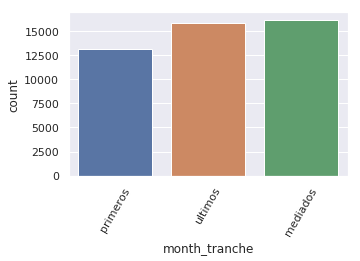

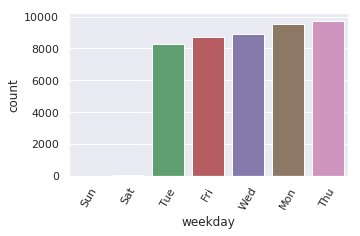

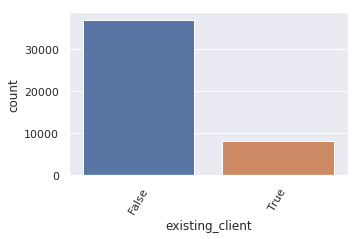

In [44]:
new_vars = ['month_tranche', 'weekday', 'existing_client']
for var in new_vars:
  value_counts = bank_df_with_transformations.groupby(var).count().toPandas().sort_values('count')
  plt.figure(figsize=(5,3))
  sns.barplot(value_counts[var], value_counts['count'])
  plt.xticks(rotation=60)

Data insights de las variables creadas:

- La distribución de llamadas es uniforme durante todo el mes
- Los dias de la semana que más llamadas se hacen son lunes y jueves
- Parece que el target comercial se concentra en nuevos clientes (al menos para este producto)

Actualizamos nuestras listas de variables: numéricas, categóricas y booleanas

In [45]:
definitive_types_list = bank_df_with_transformations.dtypes
definitive_types_list


[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'boolean'),
 ('balance', 'int'),
 ('housing', 'boolean'),
 ('loan', 'boolean'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('year', 'int'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('y', 'boolean'),
 ('date', 'date'),
 ('existing_client', 'boolean'),
 ('weekday', 'string'),
 ('month_tranche', 'string')]

In [0]:
definitive_cat = [col_name for col_name,col_type in definitive_types_list if col_type == 'string']
definitive_num = [col_name for col_name,col_type in definitive_types_list if col_type == 'int']
definitive_bool = [col_name for col_name,col_type in definitive_types_list if col_type == 'boolean']

## Análisis de outliers

Hacemos box plot de las variables numéricas a excepción de año y día, que no tiene sentido

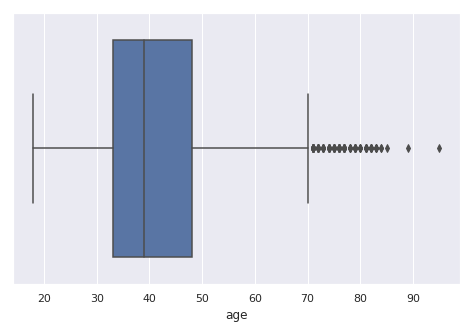

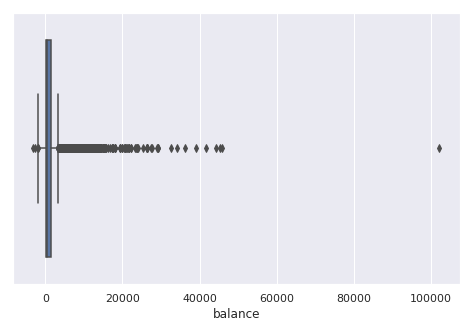

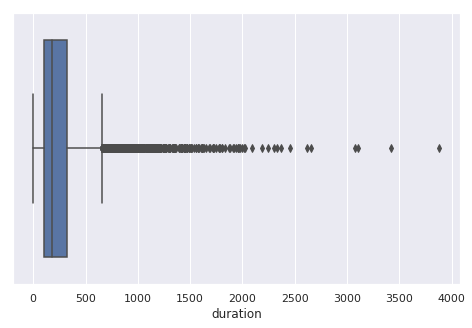

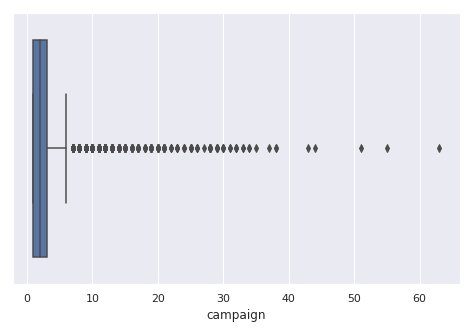

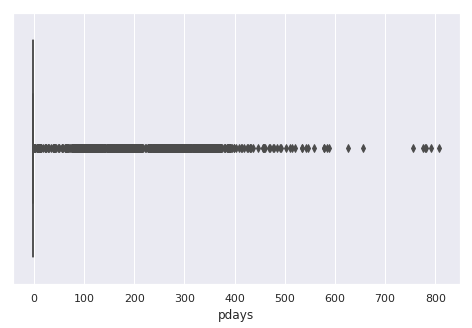

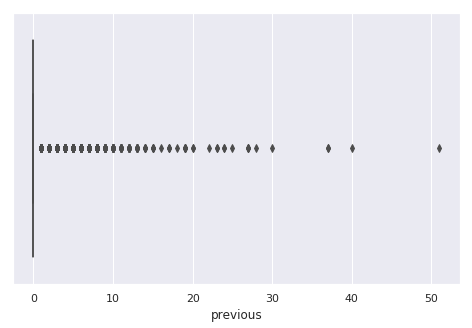

In [47]:

for var in definitive_num:
  if (var != 'day') & (var != 'year'):
    sample_data = bank_df_with_transformations.select(var).filter(F.col(var).isNotNull()).sample(False, fraction=10000/nrows, seed=77).toPandas()
    plt.figure(figsize=(8, 5))
    sns.boxplot(sample_data[var])

Detectamos outliers con test de Tukey

In [48]:
for col in definitive_num:
    q1 = bank_df_with_transformations.approxQuantile(col,[0.25], relativeError = 0.01)[0]
    q3 = bank_df_with_transformations.approxQuantile(col,[0.75], relativeError = 0.01)[0]
    iqr = q3 -q1
    min_thresh = q1 - 1.5 * iqr
    max_thresh = q3 + 1.5 * iqr
    nb_outliers = bank_df_with_transformations.select(col).filter((F.col(col) > max_thresh) | (F.col(col) < min_thresh)).count()
    if nb_outliers > 0:
      print(col,': número de outliers (Tukey) ',nb_outliers,'(',round(nb_outliers/nrows*100,2),'%)')

age : número de outliers (Tukey)  381 ( 0.84 %)
balance : número de outliers (Tukey)  4872 ( 10.78 %)
duration : número de outliers (Tukey)  3334 ( 7.37 %)
campaign : número de outliers (Tukey)  3064 ( 6.78 %)
pdays : número de outliers (Tukey)  8257 ( 18.26 %)
previous : número de outliers (Tukey)  8257 ( 18.26 %)


Data insights del estudio de outliers:

- La variable edad casi no tiene outliers, unicamente por la derecha a partir de 72 años
- El balance tiene outliers a ambos lados, saldos superiores a aproximadamente 3400 euros e inferiores a menos aproximadamente 2000 euros. Detectamos también outliers extremos (inferiores a q1 menos 3 veces el rango intercuartil y superiores a q3 mas 3 veces el rango intercuartil)
- La duración tiene bastantes outliers pero sólo por la derecha, a partir de 10'30"
- La campaña (número de contactos en campaña) tiene un comportamiento parecido considerándose outliers a partir de 6 contactos

## Análisis multivariante

### Correlaciones

Hacemos la matriz de correlación para variables numéricas

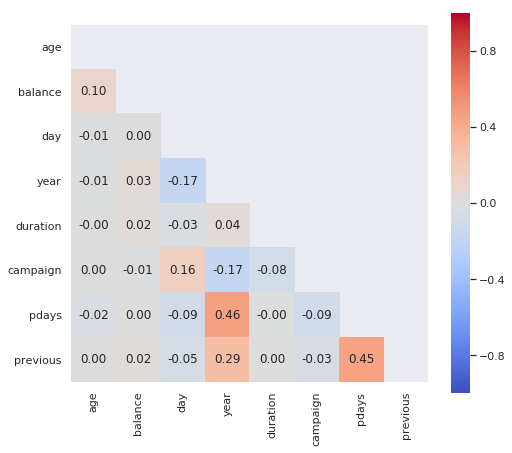

In [49]:
corr_matrix = Statistics.corr(bank_df_with_transformations.select(definitive_num).rdd.map(lambda v: Vectors.dense(v)), 
                              method='pearson')
corr_matrix = pd.DataFrame(corr_matrix, columns=definitive_num, index=definitive_num)
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
corr_matrix = corr_matrix.mask(mask)
plt.figure(figsize=(8,7))
sns.heatmap(corr_matrix, cmap='coolwarm', vmax=1, vmin=-1, square=True, annot=True, fmt='.2f')

No hay correlaciones significativas entre variables, salvo las obvias (pdays y previous). Esto significa que las variables podrían utilizarse en modelos de regresión lineal sin miedo a que la multicolinealidad introduzca ruido en el modelo

Analizamos la correlación de la variable objetivo con el resto de variables numéricas y booleanas

In [50]:
y_corrs = bank_df_with_transformations.select([F.corr(F.col('y').cast('int'), F.col(c)).alias(c) for c in definitive_num])
y_corrs.toPandas()

,age,balance,day,year,duration,campaign,pdays,previous
0,0.025155,0.052838,-0.028348,0.329994,0.394521,-0.073172,0.103621,0.093236


Como conclusión, la variable más correlacionada con nuestra variable objetivo es la duración del contacto con un 0,39 (lo cual interpretamos a mayor duración, mayor tasa de éxito en la contratación del producto)

### Tablas de contingencia

Y sacamos tablas de contingencia para el resto de variables. Previamente limpiamos de signos de puntuación los valores categóricos de job porque nos da problemas al manipular el dataframe resultante de la tabla de contingencia

In [0]:
bank_df_with_transformations = bank_df_with_transformations.withColumn('job', F.when(F.col('job') == 'admin.','admin').when(F.col('job') == 'blue-collar','blue_collar').otherwise(F.col('job')))

Primero mostramos la frecuencia de la variable objetivo para las distintas categorías. Nos interesa identificar para cada variable columnas que estén muy descompensadas porque eso significará que en esa categoría en particular hay mucha (resp. muy poca) tasa de éxito

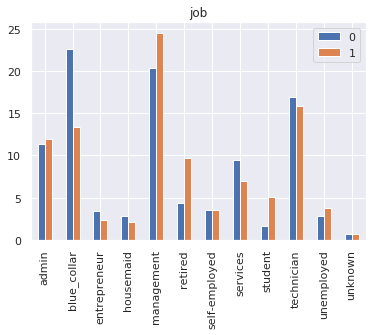

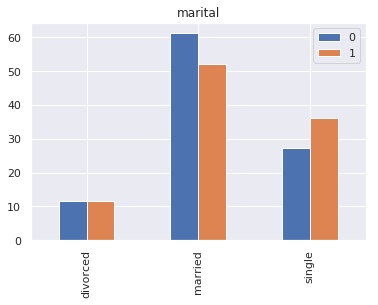

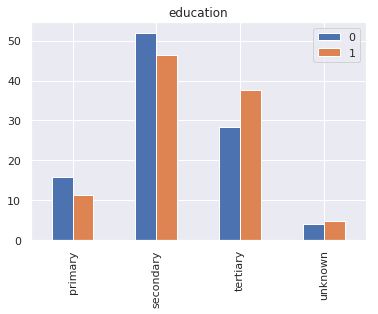

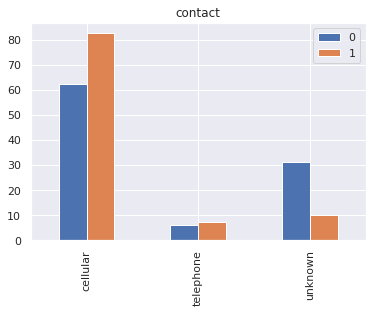

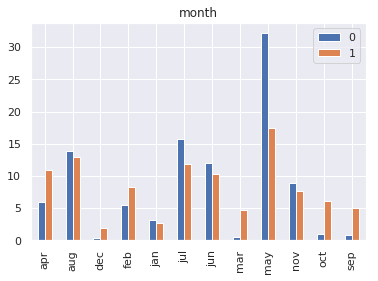

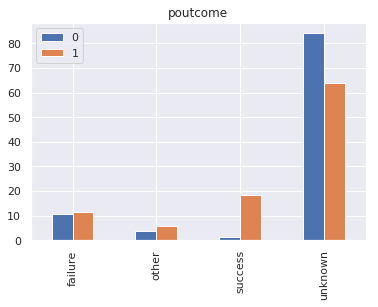

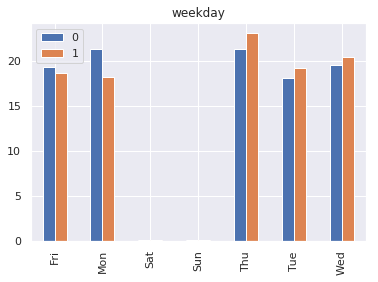

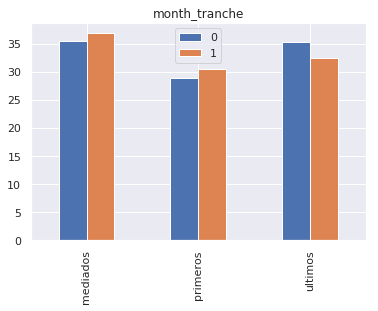

In [52]:
for col in definitive_cat:
  bank_df_with_transformations.crosstab('y',col).select(bank_df_with_transformations.crosstab('y',col).columns[1:]).toPandas().T.apply(lambda x: x/x.sum()*100, axis=0).plot(kind='bar', title=col)

Data insights de nuestro análisis bivariante entre variables categóricas y variable objetivo:

- En cuanto a la profesión, las categorías más propensas a contratar parecen ser 'Management' y, sorprendentemente 'Retired'. 'Blue collar' es la menos propensa y precisamente es la más representada en nuestra población
- Los solteros parecen más propensos a contratar que los casados
- Respecto a los estudios, contratan más los estudios superiores ('Tertiary')
- El mejor canal de contratación parece ser el móvil
- A pesar de que el esfuerzo comercial se concentra en mayo, parece ser un mes poco propenso a contratar. Los meses más eficientes son marzo, septiembre, octubre y diciembre
- Aunque no existe demasiada discriminación por día de la semana, los días centrales (de martes a jueves) parece haber mayor propensión de contratación


A continuación mostramos frecuencias relativas al total de la muestra

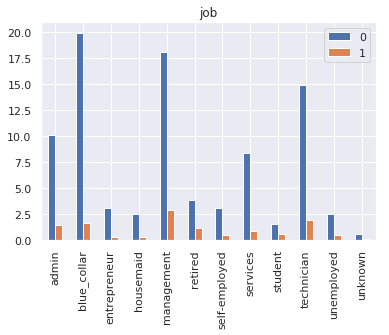

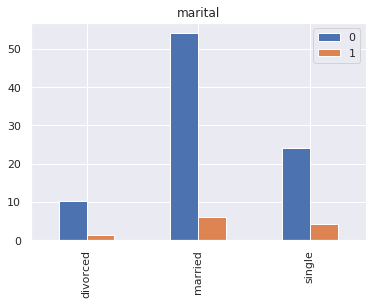

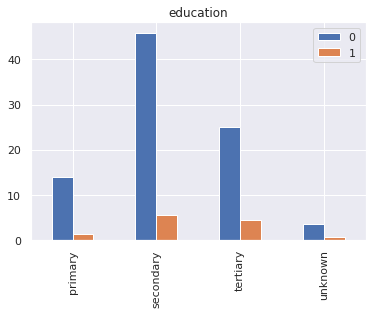

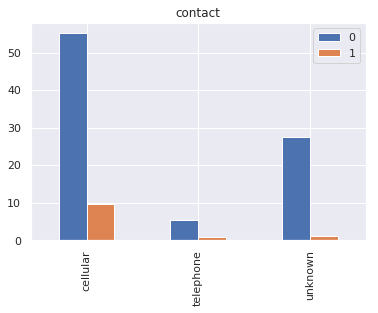

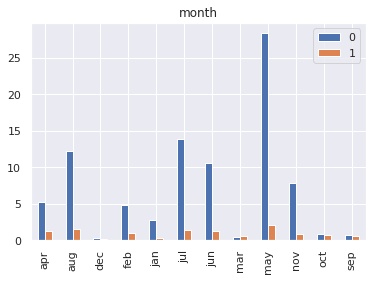

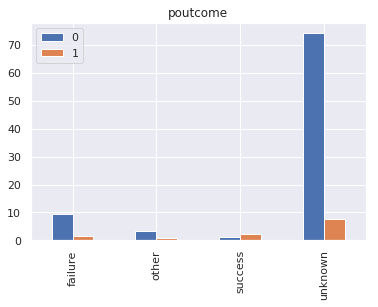

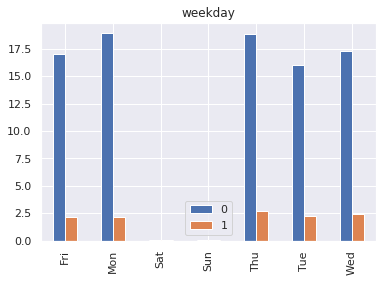

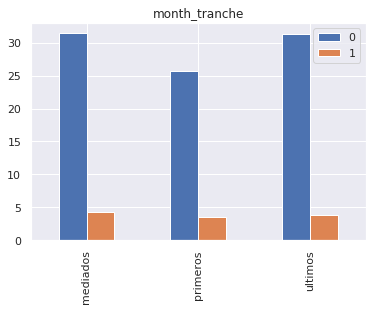

In [53]:
for col in definitive_cat:
  bank_df_with_transformations.crosstab('y',col).select(bank_df_with_transformations.crosstab('y',col).columns[1:]).toPandas().T.apply(lambda x: x/nrows*100, axis=0).plot(kind='bar', title=col)

Repetimos para las booleanas

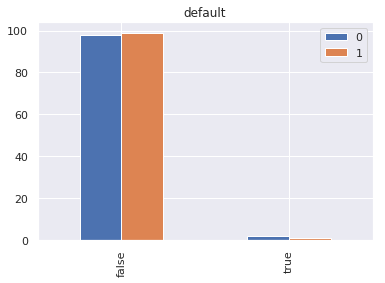

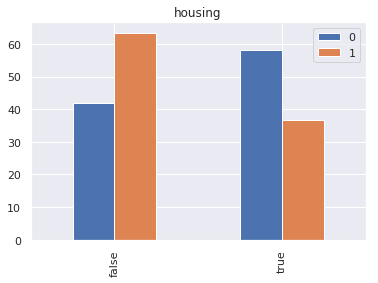

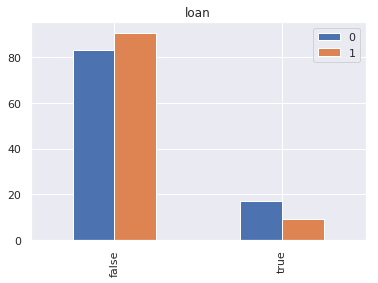

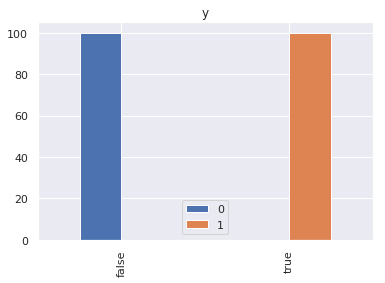

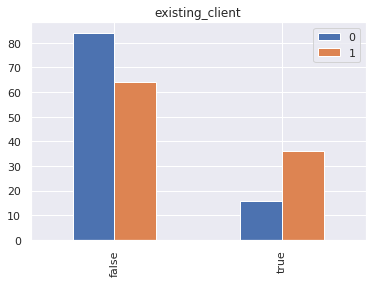

In [54]:
for col in definitive_bool:
  bank_df_with_transformations.crosstab('y',col).select(bank_df_with_transformations.crosstab('y',col).columns[1:]).toPandas().T.apply(lambda x: x/x.sum()*100, axis=0).plot(kind='bar',title=col)

Data insights del análisis bivariante de la variable objetivo con las booleanas:

- Tienden más a contratar el depósito los individuos sin hipoteca o préstamo personal
- Los clientes existentes (de campañas anteriores) son más propensos a contratar

Dejamos las tablas de contingencia de las variables categóricas en formato numérico

In [55]:
for col in definitive_cat:
  bank_df_with_transformations.crosstab('y',col).show()

+-----+-----+-----------+------------+---------+----------+-------+-------------+--------+-------+----------+----------+-------+
|y_job|admin|blue_collar|entrepreneur|housemaid|management|retired|self-employed|services|student|technician|unemployed|unknown|
+-----+-----+-----------+------------+---------+----------+-------+-------------+--------+-------+----------+----------+-------+
|false| 4540|       9024|        1364|     1131|      8157|   1748|         1392|    3785|    669|      6757|      1101|    254|
| true|  631|        708|         123|      109|      1301|    516|          187|     369|    269|       840|       202|     34|
+-----+-----+-----------+------------+---------+----------+-------+-------------+--------+-------+----------+----------+-------+

+---------+--------+-------+------+
|y_marital|divorced|married|single|
+---------+--------+-------+------+
|    false|    4585|  24459| 10878|
|     true|     622|   2755|  1912|
+---------+--------+-------+------+

+-------

Para las variables que hemos interpretado como clientes existentes (pdays y previous) vamos a analizar correlación con la variable objetivo 

In [92]:
y_corrs_clientes = bank_df_with_transformations.filter(F.col('existing_client') == True).select(F.corr(F.col('y').cast('int'), F.col('previous')))
y_corrs_clientes.show()

+------------------------------+
|corr(CAST(y AS INT), previous)|
+------------------------------+
|          0.008621542459544452|
+------------------------------+



In [93]:
y_corrs_clientes = bank_df_with_transformations.filter(F.col('existing_client') == True).select(F.corr(F.col('y').cast('int'), F.col('pdays')))
y_corrs_clientes.show()

+---------------------------+
|corr(CAST(y AS INT), pdays)|
+---------------------------+
|        -0.1522058950126687|
+---------------------------+



Conclusión: observamos correlación negativa de nuestra variable objetivo con pdays: cuantos menos días pasan desde el último contacto, mayor probabilidad de éxito

## Análisis de la evolución temporal

Mostramos la evolución temporal de las contrataciones

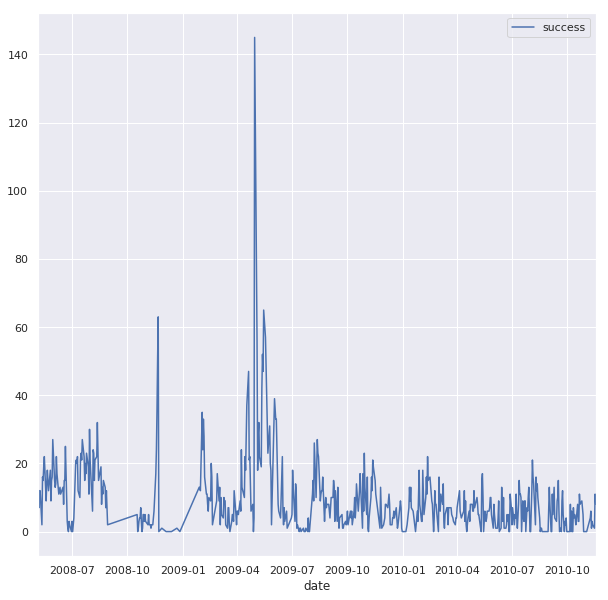

In [82]:
bank_df_with_transformations.groupBy('date').agg(F.sum(F.col('y').cast('int')).alias('success')).sort(F.col('date')).toPandas().plot('date','success', figsize=(10,10))


In [0]:
plt.plot(x,y)
plt.show()